# Stock Price Prediction: Model Training and Evaluation

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import os
import talib

In [15]:
# Load the data (make sure this path is correct and points to your data directory)
def load_data(directory='/Users/priyanshsingh/Developer/Projects/Advanced-Stocks/data'):
    all_data = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            bse_code = filename.split('.')[0]  # Extract BSE code from filename
            df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
            all_data[bse_code] = df
    return all_data

In [16]:
# Load all stock data
stock_data = load_data()

In [91]:
# Select a specific stock for analysis (e.g., the first one in the list)
selected_bse_code = list(stock_data.keys())[10]
print(selected_bse_code)
df = stock_data[selected_bse_code]

500027


In [92]:
# Perform the preprocessing steps (make sure these match what we did in the previous notebook)
# Handle missing values
df['Deliverable Quantity'].fillna(df['Deliverable Quantity'].median(), inplace=True)
df['% Deli. Qty to Traded Qty'].fillna(df['% Deli. Qty to Traded Qty'].median(), inplace=True)

In [93]:
# Create technical indicators
df['RSI'] = talib.RSI(df['Close Price'], timeperiod=14)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close Price'], fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['Close Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Generate lagged features
df['Lag_1_Close'] = df['Close Price'].shift(1)
df['Lag_2_Close'] = df['Close Price'].shift(2)
df['Lag_1_Volume'] = df['No.of Shares'].shift(1)
df['Lag_2_Volume'] = df['No.of Shares'].shift(2)

# Drop NaN values
df.dropna(inplace=True)

In [94]:
# Select features based on our previous feature selection results
selected_features = ['Lag_1_Close', 'lower_band', 'middle_band', 'Open Price', 'Spread Close-Open', 'upper_band', 'RSI', 'MACD_hist', 'MACD_signal', 'MACD']
df_selected = df[selected_features + ['Close Price']]

In [95]:
# Prepare the data
X = df_selected.drop('Close Price', axis=1)
y = df_selected['Close Price']

In [96]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [97]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    return rmse, mape

In [99]:
# 1. XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse, xgb_mape = evaluate_model(y_test, xgb_pred, "XGBoost")

XGBoost - RMSE: 556.61, MAPE: 88.28%


In [100]:
# 2. LSTM Model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse, lstm_mape = evaluate_model(y_test, lstm_pred, "LSTM")

/Users/priyanshsingh/miniconda3/envs/Advanced-Stocks/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM - RMSE: 615.08, MAPE: 98.52%


In [101]:
# 3. ARIMA + XGBoost (Hybrid Model)
# First, fit ARIMA model on the residuals
arima_order = (1, 1, 1)  # You might need to adjust these parameters
arima_model = ARIMA(y_train, order=arima_order)
arima_results = arima_model.fit()

# Make ARIMA predictions
arima_pred = arima_results.forecast(steps=len(y_test))

# Train XGBoost on the residuals
residuals_train = y_train - arima_results.fittedvalues
xgb_residual_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_residual_model.fit(X_train, residuals_train)

# Predict residuals
residuals_pred = xgb_residual_model.predict(X_test)

# Combine ARIMA and XGBoost predictions
hybrid_pred = arima_pred + residuals_pred
hybrid_rmse, hybrid_mape = evaluate_model(y_test, hybrid_pred, "ARIMA + XGBoost")

ARIMA + XGBoost - RMSE: 654.27, MAPE: 106.10%


/Users/priyanshsingh/miniconda3/envs/Advanced-Stocks/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyanshsingh/miniconda3/envs/Advanced-Stocks/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyanshsingh/miniconda3/envs/Advanced-Stocks/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/priyanshsingh/miniconda3/envs/Advanced-Stocks/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index

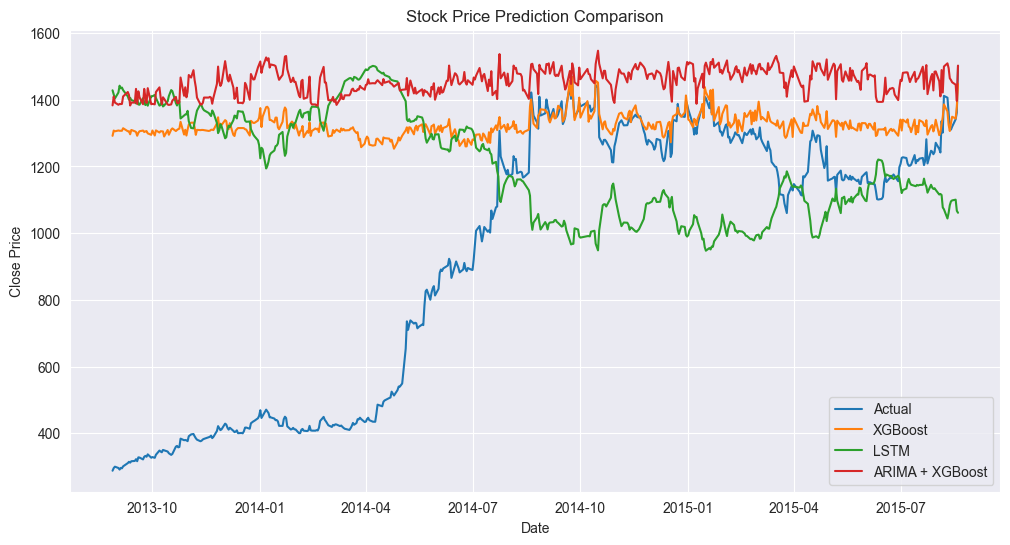

In [102]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_pred, label='XGBoost')
plt.plot(y_test.index, lstm_pred, label='LSTM')
plt.plot(y_test.index, hybrid_pred, label='ARIMA + XGBoost')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [103]:
# Print overall results
print("\nOverall Results:")
print(f"XGBoost - RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")
print(f"LSTM - RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2%}")
print(f"ARIMA + XGBoost - RMSE: {hybrid_rmse:.2f}, MAPE: {hybrid_mape:.2%}")


Overall Results:
XGBoost - RMSE: 556.61, MAPE: 88.28%
LSTM - RMSE: 615.08, MAPE: 98.52%
ARIMA + XGBoost - RMSE: 654.27, MAPE: 106.10%
